In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Ryan.Models.LSTM_model_Regression.preprocess import preprocess_data
from Ryan.Models.LSTM_model_Regression.lstm_models import  LSTMModel, LSTMModel_multi
from Ryan.Models.LSTM_model_Regression.run_fn import eval_fn, train_fn
from Ryan.Models.LSTM_model_Regression.load_data import load_data, create_sequences
from Ryan.Models.LSTM_model_Regression.load_data import load_data2
import torch
from transformers import get_linear_schedule_with_warmup
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2


## Set the hyperparameters and Load Model

In [69]:
# set the hyperparameters
data_path = 'E:\\Bristol\\mini_project\\JPMorgan_Set01\\test_datasets\\resampled_lob_secALL.csv'
sequence_length = 10
batch_size = 64
epochs = 100
test_size = 0.1
val_size = 0.1

input_size = 12
hidden_size = 256
num_layers = 2
output_size = 1
dropout_rate = 0.2
predict_steps = 1

In [70]:
# 加载训练后的模型
model = LSTMModel_multi(input_size, hidden_size, num_layers, output_size, dropout_rate, predict_steps)
model.load_state_dict(torch.load('./saved_models_regression/model_epoch_20_416.pt'))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(model)

LSTMModel_multi(
  (lstm): LSTM(12, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


## Train a new model

In [71]:
train_loader, val_loader, test_loader = load_data2(data_path, sequence_length, batch_size, test_size, val_size,
                                                      predict_steps)
print('Data loaded successfully')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = LSTMModel_multi(input_size, hidden_size, num_layers, output_size, dropout_rate, predict_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)

Data loaded successfully


In [2]:
train_losses, val_losses, train_mae, val_mae = [], [], [], []

# for epoch in range(1, epochs + 1):
#     print(f"\nEpoch {epoch}")
#     model.reset_hidden_state() # reset the hidden state for each epoch
#     train_losses,train_mae = train_fn(model, device, train_loader, optimizer, criterion, scheduler, epoch, train_losses,
#                                 train_mae)
#     val_losses,val_mae = eval_fn(model, device, val_loader, criterion, val_losses, val_mae, mode="Validation")
# 
#     # every 10 epochs save the model
#     if epoch % 10 == 0:
#         save_path = f'saved_models_regression/model_epoch_{epoch}.pt'
#         torch.save(model.state_dict(), save_path)
#         print(f"Model saved to {save_path}")

In [72]:
# test the model
test_losses, test_mae = [], []
test_losses, test_mae, test_predictions, test_actuals = eval_fn(model, device, test_loader, criterion, test_losses, test_mae, mode="Test")

100%|██████████| 5887/5887 [00:10<00:00, 564.80it/s]

Test Loss: 0.0081, MAE: 0.0329


In [3]:
# plot loss and mae
# plt.figure(figsize=(10, 6))
# plt.plot(train_losses, label='Train Loss', linewidth=2)
# plt.plot(val_losses, label='Validation Loss', linewidth=2)
# plt.title('Loss over epochs')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()


In [4]:
# plt.figure(figsize=(10, 6))
# plt.plot(train_mae, label='Train MAE', linewidth=2)
# plt.plot(val_mae, label='Validation MAE', linewidth=2)
# plt.title('MAE over epochs')
# plt.ylabel('MAE')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()

## Inverse data into original scale
For price in training set:

- max_price = 717.8333333333334
- min_price = 9.642857142857142

In [73]:
all_predictions = np.concatenate(test_predictions, axis=0)
all_actuals = np.concatenate(test_actuals, axis=0)

# 确保数据是一维的
all_predictions = all_predictions.flatten()
all_actuals = all_actuals.flatten()

# 输出形状检查
print("All Predictions Shape:", all_predictions.shape)
print("All Actuals Shape:", all_actuals.shape)

All Predictions Shape: (376719,)
All Actuals Shape: (376719,)


In [74]:
def reverse_min_max(normalized_data, min_value, max_value):
    return normalized_data * (max_value - min_value) + min_value

min_value = 9.642857142857142
max_value = 717.8333333333334

all_predictions_orig = reverse_min_max(all_predictions, min_value, max_value)
all_actuals_orig = reverse_min_max(all_actuals, min_value, max_value)

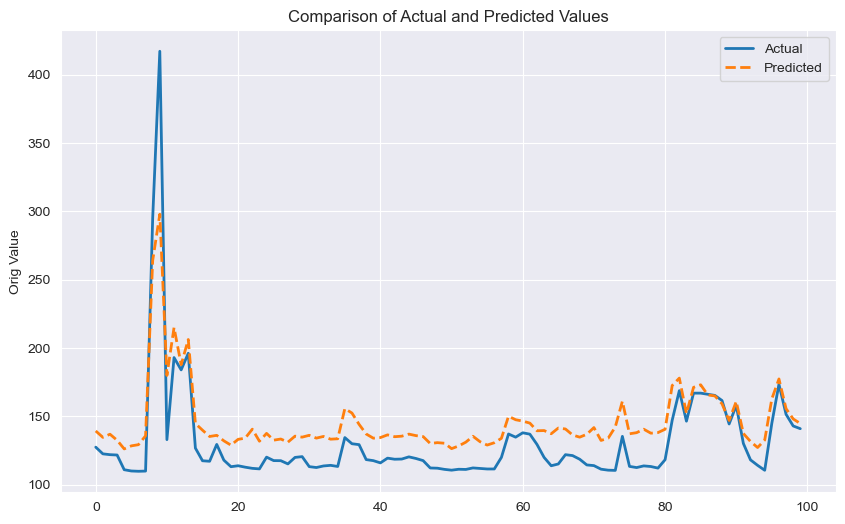

In [75]:
# the pred is one step behind the actuals , so add one for the pred
plt.figure(figsize=(10, 6))
plt.plot(all_actuals_orig[:100], label='Actual', linewidth=2)
plt.plot(all_predictions_orig[1:101], label='Predicted', linestyle='--', linewidth=2)
plt.title('Comparison of Actual and Predicted Values')
plt.ylabel('Orig Value')
plt.legend()
plt.grid(True)
plt.show()

### INSIGHTS:
从图像可以看到，基本趋势被模型捕捉到了，并且较准确，只是真实值和预测值直接仍存在约20左右的实际差距。这可能是由于数据处理使用了minmax归一化，该方法会对异常值敏感，因为它们会根据最小和最大值来缩放其他所有数据点。因此之后尝试使用z-score归一化（均值为0，标准差为1）来处理数据。

## EXP 2: Z-score Normalization 
batch size=128；
sequence length=10；
criterion = torch.nn.SmoothL1Loss()

发现使用z-score归一化，并且使用SmoothL1Loss损失函数，模型的预测与真实值差距有所下降，但是对于整体趋势的捕捉不如之前的模型。所以最终决定使用之前模型的预测作为交易模拟器的signal。

我们只需要知道价格未来的趋势而不需要知道具体数字，对于交易信号，可以将prediction的波动情况作为一个信号，当预测趋势是上升（或大幅上升等），执行买入；同理执行卖出。并结合其他信号我们可以得到最终的交易模拟器。

It was found that using z-score normalisation and using the SmoothL1Loss loss function, the model's prediction gap with the true value decreased, but the overall trend was not captured as well as the previous model. So it was finally decided to use the prediction of the previous model as the SIGNAL for the trading simulator.

We only need to know the future trend of the price and do not need to know the specific figures, for trading signals, can be prediction of the volatility of the situation as a signal, when the predicted trend is up (or sharply up, etc.), the implementation of the buy; similarly, the implementation of the sell. And combined with other signals we can get the final trading simulator.


In [5]:
def inverse_z_score(data, mean=244.47100921014294, std=75.05049341277959):
    return data * std + mean

# all_actuals_orig = inverse_z_score(all_actuals)
# all_predictions_orig = inverse_z_score(all_predictions)

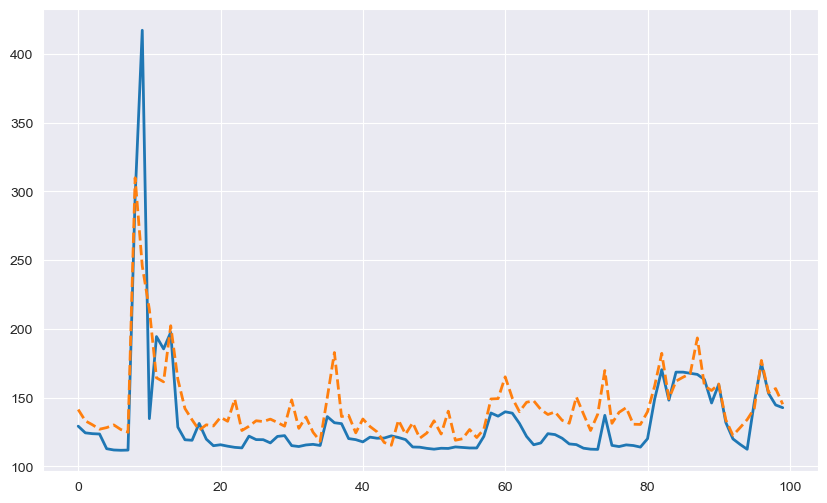

In [80]:
loaded_predictions = np.load('./saved_models_regression/predictions_zscore.npy')
loaded_actuals = np.load('./saved_models_regression/actuals_zscore.npy')

plt.figure(figsize=(10, 6))
plt.plot(loaded_actuals[:100], label='Actual', linewidth=2)
plt.plot(loaded_predictions[1:101], label='Predicted', linestyle='--', linewidth=2)

## Check the original data
The predctions and actuals' index are decided by the sequence_length, so we need to check the original data to see if the predictions and actuals are correct.

In [52]:
df=pd.read_csv(data_path)
df['price']=(df['Max Bid Price']*df['Max Bid Quantity']+df['Min Ask Price']*df['Min Ask Quantity'])/(df['Max Bid Quantity']+df['Min Ask Quantity'])

# 用最后10%的数据作为测试集, 前80%的数据作为训练集
train_size = int(len(df) * 0.8)
train_df = df[:train_size]

# 用最后10%的数据作为测试集
test_df=df[int(len(df)*0.9):]
test_df

,Datetime,Total Bid Quantity,Total Ask Quantity,Max Bid Quantity,Min Ask Quantity,Max Bid Price,Min Ask Price,price
3390556,2025-06-13 04:28:26,27,7,7,3,109,451,211.600000
3390557,2025-06-13 04:28:27,21,14,6,4,110,453,247.200000
3390558,2025-06-13 04:28:28,22,15,3,3,116,332,224.000000
3390559,2025-06-13 04:28:29,33,15,3,3,116,140,128.000000
3390560,2025-06-13 04:28:30,34,15,3,3,116,140,128.000000
...,...,...,...,...,...,...,...,...
3767280,2025-07-01 08:17:55,21,18,2,1,109,183,133.666667
3767281,2025-07-01 08:17:56,24,18,3,1,110,183,128.250000
3767282,2025-07-01 08:17:57,26,18,2,1,110,123,114.333333
3767283,2025-07-01 08:17:58,25,19,1,1,109,114,111.500000
